<a href="https://colab.research.google.com/github/Annegard/Vision-Artificial/blob/master/RedesNeuronalesConvolucionales(CNN)_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Práctico 13 - Clasificación de imágenes usando CNN
#
# En este práctico vamos a implementar un clasificador de imágenes usando CNN. El objetivo sería diseñar y entrenar un 
# algoritmo que en forma automática clasifique una imagen como correspondiente a una clase entre varias. Las clases 
# las vamos a elegir nosotros (perros y gatos, autos y motos, o algo más interesante o útil).
#
# Para probar el modelo, se deben buscar 2 imágenes nuevas, mostrarlas en pantalla (matplotlib), clasificarlas con el
# modelo y mostrar el resultado de la clasificación (score para cada clase).
# Usar template disponible en colab
#
# Fuentes:
#
# _redes convolucionales RingaTech
#  https://youtu.be/4sWhhQwHqug
#
# _Clases Grabadas de la catedra

In [23]:
####################################################LIBRERIAS################################################################
#Importamos TensorFlow que es una libreria para el aprendizaje automático. Desarrollada por Google
import tensorflow as tf
# TensorFlow es una plataforma de código abierto de extremo a extremo para el aprendizaje automático. Cuenta con un 
# ecosistema integral y flexible de herramientas, bibliotecas y recursos de la comunidad que permite que los investigadores 
# innoven con el aprendizaje automático y los desarrolladores creen e implementen aplicaciones con tecnología de AA fácilmente.
#
# Pagina Principal de Tensorflow:
# https://www.tensorflow.org/

#Los set de datos pueden ser descargados a travez de los datasets que ya posee tensorflow:
import tensorflow_datasets as tfds
# TensorFlow Datasets:
# TensorFlow Datasets es una colección de conjuntos de datos listos para usar con TensorFlow o con otros frameworks de AA de 
# Python, como Jax. Todos los conjuntos de datos se muestran como tf.data.Datasets, lo que permite canalizaciones de entrada 
# fáciles de usar y de alto rendimiento.
#
# Introduccion a la libreria tensorflow_datasets:
# https://blog.tensorflow.org/2019/02/introducing-tensorflow-datasets.html
# 
# Datasets disponibles de la libreria "tensorflow_datasets"
# https://www.tensorflow.org/datasets/catalog/overview

#from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.datasets import mnist

# Aumento de datos
# Variables para controlar las transformaciones que se haran en el aumento de datos
# utilizando ImageDataGenerator de keras
# https://torres.ai/data-augmentation-y-transfer-learning-en-keras-tensorflow/
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt #Para graficar
import math
#############################################################################################################################

In [30]:
################################################DESCARGA DEL DATASET#########################################################
# Descargamos el set de datos de TensorFlow descargandolos en datos y en metadatos.
# 
# En el primer parametro se le especifica el dataset a descargar y en los otros dos se especifica lo siguiente: 
# 
# as_supervised=True:
# Si en tfds.load "as_supervised=True", el valor devuelto "tf.data.Dataset" tendrá una estructura de 2 tuplas(input, label). 
# Si es falso, el valor devuelto "tf.data.Dataset" tendrá un diccionario con todas las funciones.
#
# with_info=True:
# Si en tfds.load "with_info=True" devolverá la tupla ( tf.data.Dataset, tfds.core.DatasetInfo), la última conteniendo la 
# información asociada al set de datos.
# 
# Asociando asi el dataset especificado en el primer parametro a la variable "Datos" y la informacion de ese dataset a la
# variable "metadatos"
#
# Fuente:
# https://www.tensorflow.org/datasets/api_docs/python/tfds/load
###
datos, metadatos=tfds.load('fashion_mnist',as_supervised=True, with_info=True)

# El dataset datos contiene 10000 datos para pruebas y 60000 para entrenar la red neuronal. Guardo dichos datos en dos 
# varIables distintas
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

# Como los metadatos traen, entre varias cosas, las categorias de datos que existen en el dataset para clasificación
# pueden visualizarse dichas categorias de la siguiente manera:
categorias=metadatos.features['label'].names
#############################################################################################################################

In [20]:
################################################NORMALIZAR LOS DATOS#########################################################
# Normalizar los datos:
# La red neuronal trabaja con datos entre 0-1 mientras que una imagen trabaja con datos entre 0-255 para imagenes en blanco 
# y negro, por lo que se requiere una normalizacion de los pixeles de la imagen para poder introducirlos en la red neuronal

def normalizar(imagenes, etiquetas):
  # Primero conviero la imagen recibida de tensorflow a una del tipo flotante para poder dividirla
  imagenes = tf.cast(imagenes, tf.float32) #https://www.tensorflow.org/api_docs/python/tf/cast
  # Despues la normalizo
  imagenes /= 255 #Divido todos los pixeles de la imagen

  return imagenes, etiquetas

# Hago pasar las tuplas para entrenar y pruebas por la funcion normalizar.
# Para ello utilizo la función .map() que devuelve un objeto mapa (que es un iterador) de los resultados 
# después de aplicar la función dada a cada elemento de un iterable dado (lista, tupla, etc.)
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

# Agregar a cache:
# Uso la memoria Cache en lugar de pedir la informacion directo del servidor para lograr un entrenamiento mas rapido
#
# Inicialmente, la memoria caché está vacía. Cuando el servidor de aplicaciones obtiene los datos del
# servidor de la base de datos, llena la memoria caché con el conjunto de datos requerido. A partir de 
# ese momento, las solicitudes subsiguientes obtienen los datos de la memoria caché en lugar de ir hasta 
# el servidor de aplicacione
# 
# el concepto de almacenamiento en caché gira en torno a la utilización de técnicas de programación para almacenar 
# datos en una ubicación temporal en lugar de recuperarlos de la fuente cada vez.
#
# https://medium.com/fintechexplained/advanced-python-how-to-implement-caching-in-python-application-9d0a4136b845
datos_entrenamiento=datos_entrenamiento.cache()
datos_pruebas=datos_pruebas.cache()

#############################################################################################################################

In [41]:
################################################CREACION DEL MODELO##########################################################

# Creacion del modelo de la red neuronal
# utilizo el Framework "Keras" para crear la red neuronal y entrenarla
# Pagina oficial del Framework:
# https://keras.io/getting_started/intro_to_keras_for_engineers/

# Modelos en Keras
# Hay dos formas de construir modelos en Keras: secuencial y funcional.
#
# El framework Keras secuencial permite crear modelos capa por capa para la mayoría de los problemas. Tiene la limitación de
# que no le permite crear modelos que compartan capas o que tengan múltiples entradas o salidas.
#
# Alternativamente, el framework Keras funcional le permite crear modelos que tienen mucha más flexibilidad, ya que puede definir 
# fácilmente modelos en los que las capas se conectan con más que solo las capas anterior y siguiente. Pudiendo conectar capas a 
# (literalmente) cualquier otra capa. Como resultado, es posible crear redes complejas como redes siamesas y redes residuales.
#
# Fuente:
# https://www.tensorflow.org/api_docs/python/tf/keras/models

# El más simple es el modelo secuencial que solo permite que las capas se agreguen en secuencia. 
modelo = tf.keras.Sequential([#Creo una red del tipo secuencial
                              
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Dropout(0.5),
                              
  tf.keras.layers.Flatten(input_shape=(28,28,1)), # Creo una capa de entrada con "un canal" al ser imagenes del tipo
                                                  # blanco y negro. Y que al trabajar con imagenes de 28x28 pixeles
                                                  # Flatten se encarga de "aplastar" dicha matriz y convertirla en una
                                                  # capa de entrada de 728 neuronas, siendo cada neurona un pixel

  tf.keras.layers.Dense(50, activation=tf.nn.relu), #Creo una capa oculta del tipo densa (que todas las neuronas
                                                    #estan internamente conectadas) y le asigno una funcion de
                                                    #activacion del tipo Relu ()
  
  # Funciones de activacion ReLu:
  # Las funciones de Rectificado lineal son transformaciones que activan un nodo sólo si la entrada está por encima de 
  # una cierta cantidad. Mientras la entrada es inferior a cero, la salida es cero, pero cuando la entrada supera un 
  # cierto umbral, tiene una relación lineal.
  #
  # Características de la función ReLU:
  #   _Activación Sparse – solo se activa si son positivos.
  #   _No está acotada.
  #   _Se pueden morir demasiadas neuronas.
  #   _Se comporta bien con imágenes.
  #   _Buen desempeño en redes convolucionales.
  # Fuente:
  # https://www.diegocalvo.es/funcion-de-activacion-redes-neuronales/

  tf.keras.layers.Dense(50, activation=tf.nn.relu), #Creo una segunda capa oculta densa de 50 neuronas con funcion
                                                    #de activacion Relu
                              
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) # Funcion de activacion de salida usualmente usada para redes de 
                                                      # clasificacion a la capa de neuronas de salida con 10 neuronas.
                              
  # A la capa de salida le asigno una funcion de activación del tipo "softmax", para que la suma de las salidas de la
  # red de clasificacion siempre me den 1 para saber cual tiene mayor probabilidad
  # Fuente:
  # https://www.tensorflow.org/api_docs/python/tf/nn/softmax
])

#############################################################################################################################

In [22]:
################################################COMPILACION DEL MODELO########################################################

# La red neuronal ahora se ha definido y debe completarse agregando un optimizador, función de pérdida y las métricas de 
# rendimiento.
# Esto se llama modelo de "compilación" en Keras.
# Fuente:
# https://www.apsl.net/blog/2018/02/02/tensor-flow-para-principiantes-vi-uso-de-la-api-keras/
modelo.compile(
    
    # Optimizador le dice como ajustar los pesos y sesgos de la red de manera Eficiente para que aprenda
    # El valor numerico es "la taza de aprendizaje" y es que tanto ajustar la red. Entre mas pequeño sea el numero
    # mas lento sera el aprendizaje. Pero si es mas grande puede no llegar al valor correcto por "pasarse de largo"
    optimizer=tf.keras.optimizers.Adam(0.001), # Para optimizar la red se utiliza "adam" 

    # Optimizador "Adam":
    # La optimización de Adam es un método de descenso de gradiente estocástico (no se que corno significa estocastico
    # y no lo pienso googlear porque el optimizador andar va a andar igual y no se quien va a leer este comentario por
    # que ya llevo mas comentario que codigo y tengo sueño) que se basa en la estimación adaptativa de momentos de primer
    # y segundo orden.
    #
    # Descenso de gradientes "adaptativo" segun el profe.
    #
    # Según Kingma (Diederik P. Kingma; Un tipo que por lo que googlie, o como se escriba googlear en pasado simple, sabe 
    # mucho de deep learning), este dijo "el método de optimizacion Adam es computacionalmente eficiente, requiere poca 
    # memoria, es invariable al cambio de escala diagonal de gradientes y es adecuado para problemas que son grandes en 
    # términos de datos/parámetros"
    #
    # Fuente:
    # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

    # Funcion de perdida/error
    #
    # tf.keras.losses.SparseCategoricalCrossentropy
    # función de pérdida de entropía cruzada cuando haya dos o más clases de etiquetas.
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),

    #Lista de métricas que evaluará el modelo durante el entrenamiento y las pruebas
    metrics=['accuracy']
)

#Guardo el numero de datos para entrenar la Red en "num_ej_entrenamiento"
num_ej_entrenamiento = metadatos.splits["train"].num_examples
#Guardo el numero de datos para entrenar la Red en "num_ej_pruebas"
num_ej_pruebas = metadatos.splits["test"].num_examples

#Al haber 60000 ejemplos, para hacer que entrene mas rapido esta informacion se puede dividir en lotes
TAMANO_LOTE = 32

# Como recorreremos varias veces el Dataset queremos que sea aleatorio, por lo que se utiliza la funcion
# repeat, shuffle Y batch para recorrerla de distintas maneras y por lotes
# https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
#
# Al metodo repeat() le damos el dato y damos el número de cuantas veces se repetirá el dato. Si no vamos a especificar 
# el número, se repetirá infinitas veces.
# https://www.geeksforgeeks.org/python-itertools-repeat/
#
# El metodo shuffle() toma una secuencia, como una lista, y reorganiza el orden de los elementos
# https://www.w3schools.com/python/ref_random_shuffle.asp

# El metodo batch() El ds.batch() tomará las primeras X cantidad de entradas definidas en TAMANO_LOTE y hará un lote con 
# ellas. Entonces, un tamaño de lote de 32 para nuestro conjunto de datos de ejemplo producirá 1.875 registros de lote.
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_prueba = datos_pruebas.batch(TAMANO_LOTE)

# A entrenar:
#
# A la funcion fit() se le indican los datos de entrada, los que se requieren de salida (no se porque eso es opcional), y las
# vueltas que se quiere que se intente (epochs)
# Fuente fit(parametros internos y otras yerbas):
# https://www.tensorflow.org/api_docs/python/tf/keras/Model
#
historial = modelo.fit(datos_entrenamiento, epochs=10, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

#############################################################################################################################

Epoch 1/10
1875/1875 [==============================] - 60s 28ms/step - loss: 0.5510 - accuracy: 0.7963
Epoch 2/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.3801 - accuracy: 0.8615
Epoch 3/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.3279 - accuracy: 0.8791
Epoch 4/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.2996 - accuracy: 0.8894
Epoch 5/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2845 - accuracy: 0.8947
Epoch 6/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.2695 - accuracy: 0.8993
Epoch 7/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.2550 - accuracy: 0.9064
Epoch 8/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.2467 - accuracy: 0.9077
Epoch 9/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2399 - accuracy: 0.9108
Epoch 10/10
1875/1875 [==============================] - 56s 30m

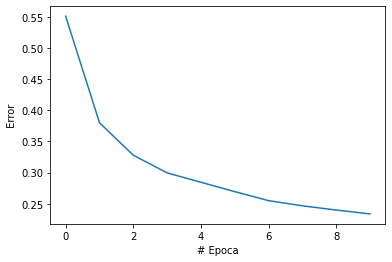

In [42]:
#####################################################RESULTADOS##############################################################
plt.figure("Error")
plt.xlabel("# Epoca")
plt.ylabel(" Error ")
plt.plot(historial.history["loss"])
plt.show()
#############################################################################################################################